# Homework 2 classification

### task: whether the income of an individual exceeds 50000 dollars or not?

using the data of:

processes:
1. remove unnecessary sttributes
2. create a model (gx>0, exceeds, <0, not) and the loss function
3. conclusion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# data = pd.read_csv('./Documents/LeeML-datasets/hw2/data/train.csv')

In [2]:
# data.head()

## Logistic Regression 逻辑回归


1. preparing data


In [53]:
np.random.seed(0)
X_train_fpath = './Documents/LeeML-datasets/hw2/data/X_train'
Y_train_fpath = './Documents/LeeML-datasets/hw2/data/Y_train'
X_test_fpath = './Documents/LeeML-datasets/hw2/data/X_test'
output_fpath = './output_{}.csv'

# using next function to read file, only read one line at a time???
with open(X_train_fpath) as f:
    next(f)
    # using file as an iterator???
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
    # each line in file, strip off the end mark, and split them by comma, and view data as float

with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)


2. functions preparation:

    normalize the data, each x is processed by (x - x_mean) / x_std, and split data into training set and development set(validation set???)
    
    also: learning how to write a clear function, with parameters' and return values' details in annotations.

In [54]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific column of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments (details):
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specified_column: if 'None', all columns will be normalized
    #     omit the rest......
    # Outputs:
    #     X: normalized data
    #     omit the rest......
    
    if specified_column == None:
        specidied_column = np.arange(X.shape[1])
        # arange means a range, provide spaced values within a given interval
        # shape[1] means the columns count
    if train:
        X_mean = np.mean(X[:, specidied_column], 0).reshape(1,-1)
        X_std = np.std(X[:, specidied_column], 0).reshape(1,-1)
    
    X[:, specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
    # 1e-8, in case std is zero
    
    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function splits data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _ = _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

# Split data into training and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)
# now X_train is smaller and it is a part of original train set

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))
#print('X_train content brief: {}'.format(X_train[:8][:50])) 
# apparently my normalizing has some errors, there are bigger than 1, and smaller than -1.
# However,,, it is the probabilitic normalizing

Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510


In [4]:
print(X_train.shape)
print(Y_train.shape)

(48830, 510)
(48830, 1)


### some useful Functions

 that will be repeatedly used when iteratively updating the parameters.

In [55]:
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):
    # Sigmoid function can be used to calculate probability
    # To avoid overflow, minimum/maximum output value is set.
    # API application programming interface
    # (clip function is used when it is smaller than 1e-8, it will be assigned to 1e-8.)
#     z = np.abs(z)
    # to avoid z is smaller than 0
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):
#     This is the logictic regression function
    
#     Arguements:
#         X: input data, shape = [batch_size, data_dimension]
#         w: weight vector, shape = [data_dimension]
#         b: bias, scalar
#     Output:
#         predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)

def _predict(X, w, b):
    # This function returns a truth value prediction of each row of X
    # by rounding the result of logistic regression function
    return np.round(_f(X, w, b)).astype(np.int)

def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

### Functions about gradient and cross entropy loss



In [56]:
def _cross_entropy_loss(Y_pred, Y_label):
#     This function computes the cross entropy
    
#     Arguements:
#         Y_pred: probabilistic predictions, float vector
#         Y_label: ground truth labels, bool vector
#     Outputs:
#         cross entropy, scalar
    ones = np.ones((Y_pred.shape[0], 1),dtype = int)
#     print('ones\' shape: {}'.format(ones.shape))
#     print('Y_label shape: {}'.format(Y_label.shape))
#     print('Y_pred shape: {}'.format(Y_pred.shape))
    
    # This is a bad feature and a good convinience in python, I don't need to claim my data type, and I can be easily confused...
    # if I changed the ones from (n,) to (n,1),I need to use matmul function
    # cross_entropy = -np.dot(Y_label, np.log(Y_pred)) - np.dot((1 - Y_label), np.log(1 - Y_pred))
    # can it be 1 or an array of 1?
    # Is it because there are two possible results, so it is Y_label and (1 - Y_label) ???
    # dot product of two arrays, matmul for matrix multiplication
    
    cross_entropy = -np.matmul(Y_label.T, np.log(Y_pred)) - np.matmul((ones - Y_label).T, np.log(ones - Y_pred))
    # print('cross_entropy shape: {}'.format(cross_entropy.shape)) # 1 * 510
    '''
    it turns out that I miss-calculated this cross entropy's size, caused that every thing is based on the first weight,,,,
    no wounder the results are all the same.
    20210511: and ,,,,I also made a mistake in gradient, cross entropy should be (1,1) shape instead of (1*510)
    '''
    cross_en = np.sum(cross_entropy, 1)
    
    return cross_en[0] / 510

def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight and bias.
    Y_pred = _f(X, w, b)
    pred_error = Y_label - Y_pred
    w_grad = -np.sum(np.matmul(X.T, pred_error), 1) # -np.sum(pred_error * X.T,1)
    # print('shape of X.T * pred_error: {}'.format(np.shape(np.matmul(X.T, pred_error))))
    # X.T, returns the transpose of the matrix
    w_grad = w_grad.reshape(data_dim,1)
    '''
    It is because I used np.sum,so w_grad is turned into a 1D array, 
    however the later calculation is all matrix, so I need to transform it into (510, 1)shape.
    '''
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad


### Training

Mini-batch gradient descent is used here.

Training data are split into several mini-batches and each batch is fed into the model sequentially for losses and gradients computation.

Weights and bias are updated on a mini-batch basis.

Once we have gone through the whole training set, data have to reshuffled and continue, until max number of iterations is reached.


In [57]:
# _shuffle(X, Y) _f(X, w, b) 
# train_size = X_train.shape[0]
# dev_size = X_dev.shape[0]
# test_size = X_test.shape[0]
# data_dim = X_train.shape[1]
w = np.zeros((data_dim, 1))
b = np.zeros((1, 1))

# some parameters for training
max_iter = 20
batch_size = 8
learning_rate = 0.2

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Calculate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begining of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
    
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        # using batch size to splits set into batches
        # choosing present batch
        X = X_train[idx*batch_size : (idx + 1)*batch_size]
        Y = Y_train[idx*batch_size : (idx + 1)*batch_size]
        # only 8 a batch
        
        # Compute the gradient
        
        w_grad, b_grad = _gradient(X, Y, w, b)
#         print('after gradient w_grad: {}'.format(w_grad.shape))
        
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate / np.sqrt(step) * w_grad
        b = b - learning_rate / np.sqrt(step) * b_grad
        
        step = step + 1
        
    # Compute loss and accuracy of training set and development set
    
#     print('w: {}'.format(w.shape))
#     print('b: {}'.format(b.shape))
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    # y is a fraction, and Y is true or false
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)
    
    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)
    
print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))
    

Training loss: 0.0005253379569813624
Development loss: 0.0005607116557371383
Training accuracy: 0.885398320704485
Development accuracy: 0.8776262440103206


# Problems of logistic regression implementation:

### OMG I just experienced an overflow with my sys can't work for a minute

##### 1. showing this:
RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
  
##### 2. when i use accuracy and cross entropy function:
Unable to allocate 17.8 GiB for an array with shape (48830, 48830) and data type float64

###### related code:

In [9]:
'''
acc = 1 - np.mean(np.abs(Y_pred - Y_label))
cross_entropy = -np.dot(Y_label, np.log(Y_pred)) - np.dot((1 - Y_label), np.log(1 - Y_pred))
w_grad = -np.sum(np.matmul(X.T, pred_error)) # -np.sum(pred_error * X.T,1)
'''

'\nacc = 1 - np.mean(np.abs(Y_pred - Y_label))\ncross_entropy = -np.dot(Y_label, np.log(Y_pred)) - np.dot((1 - Y_label), np.log(1 - Y_pred))\nw_grad = -np.sum(np.matmul(X.T, pred_error)) # -np.sum(pred_error * X.T,1)\n'

#### Finally knoweledge some tricks:
1. array vs matrix:

    an array: one dim's shape is (n,)
    
    an matrix: two dim's shape is (n,1)
    
    I need to unify the shape of all mat, though the original answer used array, I used matrix to calculate them all......

2. matrix multiplication:

    pred_error shape: 8 * 1

    X.T: 510 * 8

    for each weight: using all 8 examples to calculate its gradient

3. dot vs matmul function:

    notice that dot is for array operation, matmul is for matrix multiplication

4. cross entropy:

    cross entropy need the sum of all (y_pred & y_label)

    because I used matrix, so I need to sum them all.
    
5. sigmoid function:

    I can't absolute the value...
    
6. np.sum function produces (n,) 1D array:
    
    I need to transform them into (1, 1) shape, because I changed all the related shape for being stupid.
    
#### still sometimes it will show: RuntimeWarning: overflow encountered in exp

## OMG, I finally get through this crafts!!!!

##### About the results: (ignoring the overfitting pobability)
with (iteration, batch_size, learning_rate):

with (10, 8, 0.2):

Training loss: 0.0005301466016276826
Development loss: 0.0005784212337425157
Training accuracy: 0.8836553120804606
Development accuracy: 0.8707761621953717

with (20, 8, 0.2):

Training loss: 0.0005202315116036872
Development loss: 0.0005567861298706374
Training accuracy: 0.8852936491683163
Development accuracy: 0.8763055498668851
**iteration more can bring better results**

with (10, 8, 0.1):

Training loss: 0.0005212379485006333
Development loss: 0.0005670887760806337
Training accuracy: 0.8862721004846748
Development accuracy: 0.8769199262748311
**smaller learning rate may be better**

with (20, 8, 0.1):

Training loss: 0.0005169539471113908
Development loss: 0.0005577155160624136
Training accuracy: 0.8862948551664505
Development accuracy: 0.8756911734589392 
**why? with iteration is bigger the development acc is a little lower**

with (10, 800, 0.2):

Training loss: 0.0022635963479965392
Development loss: 0.0024438673516984457
Training accuracy: 0.840057341798075
Development accuracy: 0.8222404259676428
**batch size can't be too big**

with (10, 5, 0.2):

Training loss: 0.000526964536633294
Development loss: 0.0005648515688799896
Training accuracy: 0.8852936491683163
Development accuracy: 0.8703665779234078
**batch size too small is also no good**

### Plotting Loss and Accuracy Curve


In [28]:
# import sys
# !{sys.executable} -m pip install matplotlib
# why it can't work!!!!!??????
# maybe it is because I open two kernels, for some reasons

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 48-49: truncated \uXXXX escape (<ipython-input-28-fdcdf9400eaa>, line 14)

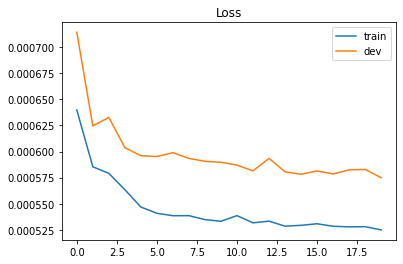

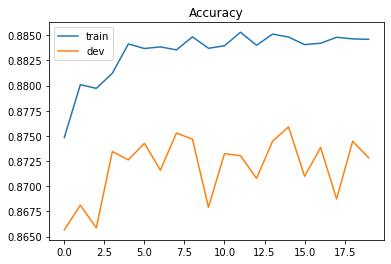

In [44]:

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train','dev'])
plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train','dev'])
plt.savefig('acc.png')
plt.show()


with lower learning rate, though, train data will be better, the dev data will be a mess.

so I still choose the (20, 8, 0.2) set.

### Predicting testing labels

predictions are saved to output_logistic.csv.

In [58]:
# Predict testing labels
predictions = _predict(X_test, w, b)

predictions = predictions.reshape(test_size,)
# change all the results back from (n, 1) to (n, )

with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in enumerate(predictions):
        f.write('{},{}\n'.format(i, label))
        
# Print out the most significant weights
w = w.reshape(data_dim,)
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Not in universe -3.815324552342815
 Spouse of householder -1.6340384205593481
 Other Rel <18 never married RP of subfamily -1.4214203744319514
 Child 18+ ever marr Not in a subfamily -1.2970646036647804
 Other Rel <18 ever marr RP of subfamily -1.1699963394925046
 Unemployed full-time 1.1275472914341786
 Italy -1.0956626808773617
 Vietnam -1.0683481322966883
num persons worked for employer 0.9416708774433548
 1 0.8075576048491324


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Kaggle results

I finally get into the simple baseline!!! **Hurray**

### Generative model

I just copied the answers online, because of exhausted... by logistic model....

In [47]:
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

In [48]:
# Compute in-class mean
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0)  

# Compute in-class covariance
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# Shared covariance is taken as a weighted average of individual in-class covariance.
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])

In [49]:
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# Directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# Compute accuracy on training set
Y_train_pred = 1 - _predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.8727882630492481


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [50]:
# Predict testing labels
predictions = 1 - _predict(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])


 Retail trade 8.33837890625
 34 -6.43798828125
 37 -5.947265625
 Tennessee 5.6171875
 Other service -5.38916015625
 29 -4.90771484375
 Forestry and fisheries 4.765625
 Finance insurance and real estate -4.087890625
 7 4.0361328125
 3 -3.64453125


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
